 # Setup, Pre-processing, and data cleaning
 

In [90]:
import os
import time
import random
import warnings
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
  roc_auc_score, brier_score_loss,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

from xgboost import XGBClassifier

warnings.filterwarnings("ignore")


In [91]:
SEED = 42
random.seed(SEED)

np.random.seed(SEED)

import sklearn
sklearn.utils.check_random_state(SEED)

os.environ["PYTHONHASHSEED"] = str(SEED)

In [92]:
# ----------------------------------------------------------
# Load data from local copy of cs_bisnode_panel.csv
# ----------------------------------------------------------
url = "https://osf.io/7s5yb/download?version=1"
response = requests.get(url)
df = pd.read_csv(StringIO(response.text))
# Initial inspection
info = df.info()
head = df.head()
columns = df.columns.tolist()

desc = df.describe(include='all')

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1.001034e+06,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1.001034e+06,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1.001034e+06,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1.001034e+06,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1.001034e+06,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287824,4.641209e+11,2011-01-01,2011-12-31,NaN,0.000000,1807.407349,3.703704,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287825,4.641209e+11,2012-01-01,2012-12-31,NaN,0.000000,1518.518555,96.296295,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287826,4.641209e+11,2013-01-01,2013-12-31,NaN,0.000000,988.888916,77.777779,0.0,0.0,0.0,...,NaN,NaN,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287827,4.641209e+11,2014-01-01,2014-12-31,NaN,0.000000,644.444458,233.333328,0.0,0.0,0.0,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN


In [93]:
print(df["year"].min(), "→", df["year"].max())
# Initial count before cleaning
initial_count = df['comp_id'].nunique()
print(f"Initial number of unique companies: {initial_count}")

2005 → 2016
Initial number of unique companies: 46412


In [94]:
# Convert year to integer and restrict panel to 2010–2015
df['year'] = df['year'].astype(int)
df = df[(df['year'] >= 2010) & (df['year'] <= 2015)].copy()

# Drop sparse or redundant columns
df = df.drop(columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"], errors='ignore')

# ----------------------------------------------------------
# Create lagged variables and filter based on exit status
# ----------------------------------------------------------
# Sort for consistency
df.sort_values(by=['comp_id', 'year'], inplace=True)

# Generate t+1 values for growth computation
df['sales_next'] = df.groupby('comp_id')['sales'].shift(-1)
df['labor_next'] = df.groupby('comp_id')['labor_avg'].shift(-1)
df['year_next'] = df.groupby('comp_id')['year'].shift(-1)
df['exit_year'] = pd.to_numeric(df['exit_year'], errors='coerce')

# Drop firms that exited before t+1
df = df[(df['exit_year'].isna()) | (df['exit_year'] > df['year'])]

# Drop rows without valid sales data for t and t+1
df_clean = df.dropna(subset=['sales', 'sales_next']).copy()
df_clean['sales'] = pd.to_numeric(df_clean['sales'], errors='coerce')
df_clean['sales_next'] = pd.to_numeric(df_clean['sales_next'], errors='coerce')

# ----------------------------------------------------------
# Identify firms with valid, positive sales in both 2012 and 2013
# ----------------------------------------------------------
sales_years = df_clean[df_clean['year'].isin([2012, 2013])]
valid_sales_firms = (
    sales_years[(sales_years['sales'] > 0)]
    .groupby('comp_id')['year']
    .nunique()
)
complete_firms = valid_sales_firms[valid_sales_firms == 2].index

# Final dataset
df_final = df_clean[df_clean['comp_id'].isin(complete_firms)]
final_count = df_final['comp_id'].nunique()

print(f"Final number of unique companies: {final_count}")


Final number of unique companies: 18787


# Target Variable Construction – Fast Growth

In [95]:
# Filter for 2012 as base year for 1-year growth
df_growth = df_clean[(df_clean['year'] == 2012) & (~df_clean['sales_next'].isna())]
df_growth = df_growth[(df_growth['exit_year'].isna()) | (df_growth['exit_year'] > 2013)]
# Remove firms with zero sales in base year
df_growth = df_growth[df_growth["sales"] != 0]

# Compute sales growth and remove outliers
df_growth['sales_growth'] = (df_growth['sales_next'] / df_growth['sales']) - 1
df_growth = df_growth[(df_growth['sales_growth'] > -1) & (df_growth['sales_growth'] < 10)]

# Define binary target: top 10% = fast growth
growth_threshold = df_growth['sales_growth'].quantile(0.90)
df_growth['fast_growth_sales'] = (df_growth['sales_growth'] >= growth_threshold).astype(int)
df_growth

# ----------------------------------------------------------
print('Final number of unique companies:', df_growth['comp_id'].nunique())

Final number of unique companies: 19446


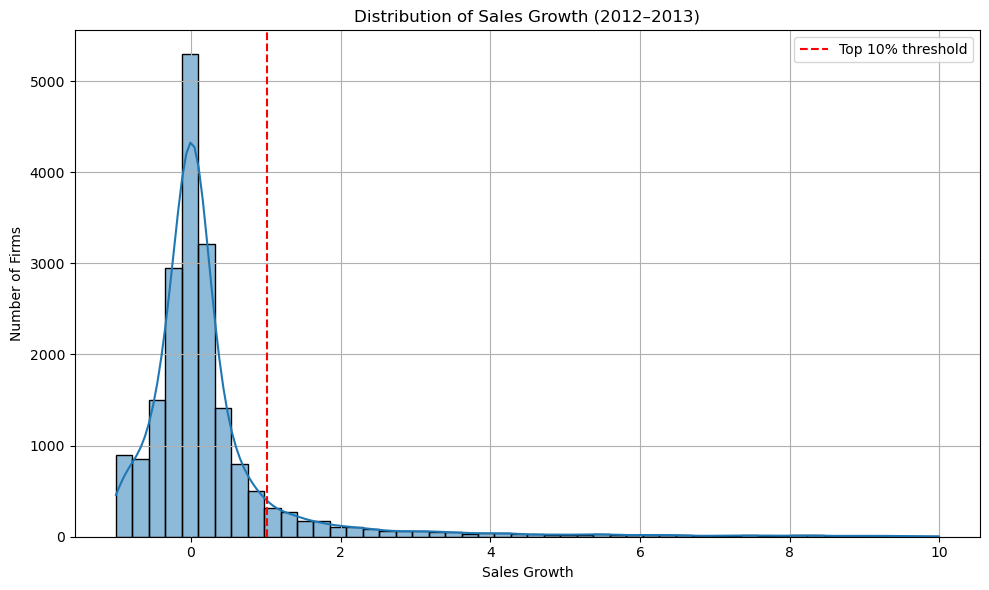

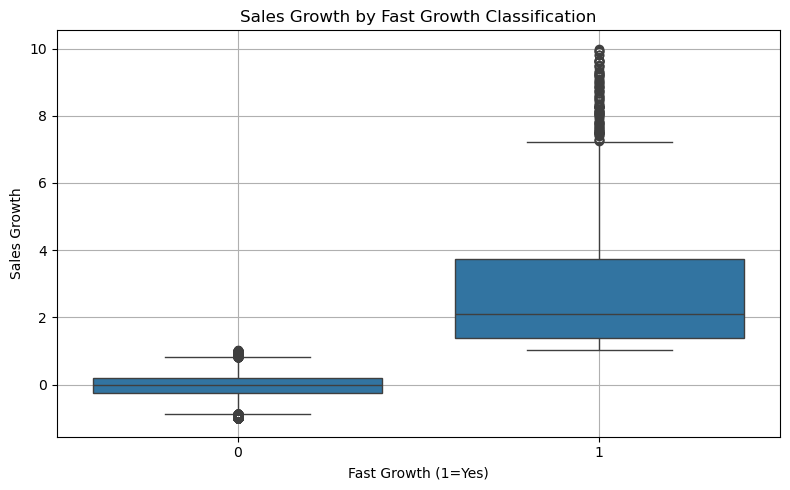

In [96]:
# ----------------------------------------------------------
# Visualize Target Variable Distribution
# ----------------------------------------------------------

plt.figure(figsize=(10, 6))
sns.histplot(df_growth['sales_growth'], bins=50, kde=True)
plt.axvline(growth_threshold, color='red', linestyle='--', label='Top 10% threshold')
plt.title('Distribution of Sales Growth (2012–2013)')
plt.xlabel('Sales Growth')
plt.ylabel('Number of Firms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='fast_growth_sales', y='sales_growth', data=df_growth)
plt.title('Sales Growth by Fast Growth Classification')
plt.xlabel('Fast Growth (1=Yes)')
plt.ylabel('Sales Growth')
plt.grid(True)
plt.tight_layout()
plt.show()


In [97]:
# ----------------------------------------------------------
# Summary statistics by growth class
# ----------------------------------------------------------
summary_stats = df_growth.groupby('fast_growth_sales')['sales_growth'].describe()
summary_stats

,count,mean,std,min,25%,50%,75%,max
fast_growth_sales,,,,,,,,
0,17501.0,-0.026828,0.395133,-0.999920,-0.234542,-0.003367,0.186732,1.016830
1,1945.0,2.932783,2.075946,1.017191,1.400000,2.109517,3.730290,9.992043


In [98]:
# ----------------------------------------------------------
# separate dataframes for modelling and post-modeling evaluations
# ----------------------------------------------------------
df_full = df.copy()  # Keep all variables
# Keep final feature and control set
columns_to_keep = [
    'comp_id', 'year', 'sales', 'labor_avg', 'sales_next', 'sales_growth', 'fast_growth_sales',
    'nace_main', 'ind2', 'region_m', 'urban_m',
    'foreign', 'female', 'ceo_count', 'inoffice_days'
]
df_model = df_growth[columns_to_keep].copy()  # Use for modeling

In [99]:
#-----------------------------------------------------------
# Data Cleaning
#-----------------------------------------------------------
# Drop rows missing target-defining variables
df_model = df_model.dropna(subset=['sales', 'sales_next', 'sales_growth'])

# Impute missing categorical controls
df_model['region_m'] = df_model['region_m'].fillna('Unknown')
df_model['nace_main'] = df_model['nace_main'].fillna(-1)

# Impute numeric controls and add missingness flags
for col in ['foreign', 'female', 'ceo_count', 'inoffice_days']:
    df_model[f'{col}_missing'] = df_model[col].isna().astype(int)
    df_model[col] = df_model[col].fillna(df_model[col].median())
# Final overview
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19446 entries, 14 to 287814
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   comp_id                19446 non-null  float64
 1   year                   19446 non-null  int64  
 2   sales                  19446 non-null  float64
 3   labor_avg              16644 non-null  float64
 4   sales_next             19446 non-null  float64
 5   sales_growth           19446 non-null  float64
 6   fast_growth_sales      19446 non-null  int64  
 7   nace_main              19446 non-null  float64
 8   ind2                   19440 non-null  float64
 9   region_m               19446 non-null  object 
 10  urban_m                19446 non-null  int64  
 11  foreign                19446 non-null  float64
 12  female                 19446 non-null  float64
 13  ceo_count              19446 non-null  float64
 14  inoffice_days          19446 non-null  float64
 15  forei

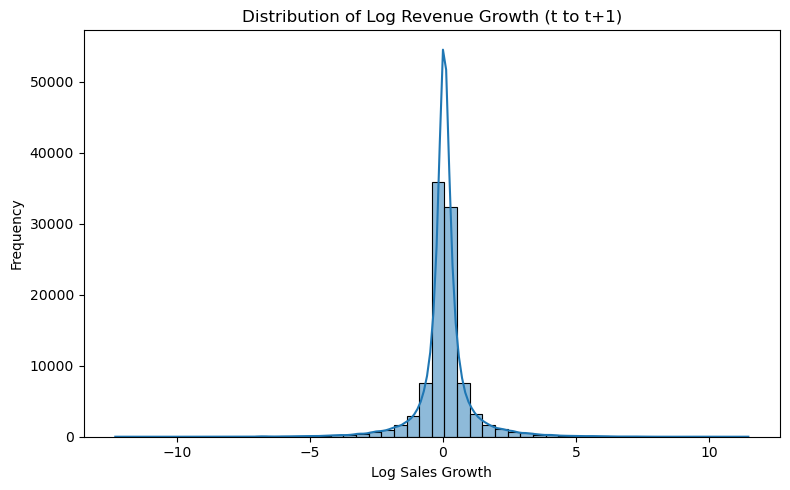

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,ind,urban_m,region_m,founded_date,exit_date,labor_avg,sales_next,labor_next,year_next,log_sales_growth
5,1001034.0,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,637.037048,...,3.0,1,Central,1990-11-19,NaN,0.083333,0.0,0.083333,2011.0,-inf
6,1001034.0,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,481.481476,...,3.0,1,Central,1990-11-19,NaN,0.083333,0.0,0.083333,2012.0,NaN
7,1001034.0,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,340.740753,...,3.0,1,Central,1990-11-19,NaN,0.083333,0.0,NaN,2013.0,NaN
8,1001034.0,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,200.000000,...,3.0,1,Central,1990-11-19,NaN,NaN,0.0,NaN,2014.0,NaN
9,1001034.0,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,170.370377,...,3.0,1,Central,1990-11-19,NaN,NaN,0.0,NaN,2015.0,NaN


In [100]:

df_clean['log_sales_growth'] = np.log(df_clean['sales_next'] / df_clean['sales'])

plt.figure(figsize=(8, 5))
sns.histplot(df_clean['log_sales_growth'], bins=50, kde=True)
plt.title("Distribution of Log Revenue Growth (t to t+1)")
plt.xlabel("Log Sales Growth")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

df_clean.head()


## Constructing Alternative Fast-Growth Targets

To evaluate the robustness of our firm growth prediction models, we construct three distinct binary target variables based on sales growth over time:

1. **1-Year Sales Growth (2012–2013)**: Captures short-run momentum. It is sensitive to temporary shocks and may be influenced by year-specific conditions.
2. **2-Year Compound Annual Growth Rate (CAGR, 2012–2014)**: Captures sustained growth over time. It smooths year-to-year volatility and better reflects long-term business expansion.
3. **Log Sales Growth (2012–2013)**: Accounts for proportional growth and is more robust to extreme values. Often used in econometric models for its interpretability and distributional properties.

By comparing model performance across these three definitions, we aim to identify which growth indicator yields the most predictable and stable signals of "fast growth" among firms. This strategy helps ensure that our final model choice is not overly dependent on a single target definition, enhancing both credibility and generalizability of our findings.


In [101]:
# === Step 1: Extract relevant columns for growth computation ===
df_sales = df_clean[["comp_id", "year", "sales", "exit_year"]].copy()

# Step 2: Filter to key years for growth (2012, 2013, 2014)
df_sales = df_sales[df_sales["year"].isin([2012, 2013, 2014])]

# Step 3: Pivot to wide format for sales
sales_pivot = df_sales.pivot(index="comp_id", columns="year", values="sales")

# Step 4: Filter to active firms (not exited before 2014)
exit_info = df_clean.groupby("comp_id")["exit_year"].first()
active_firms = exit_info[(exit_info.isna()) | (exit_info >= 2014)].index
sales_pivot = sales_pivot.loc[sales_pivot.index.isin(active_firms)]


## Feasibility of CAGR as a Target Variable

To ensure the reliability of CAGR (Compound Annual Growth Rate) as a target, we examined data availability across years. Out of 25,044 firms with non-missing sales data in 2012, 21,315 (85.11%) had valid observations in both 2012 and 2014 — making CAGR a feasible and robust candidate for identifying fast-growing firms over a two-year horizon.

This high data retention supports our decision to include CAGR-based classification alongside one-year sales growth and log-growth targets.

In [102]:
df_sales = df_sales[["comp_id", "year", "sales", "exit_year"]].copy()

# Step 2: Filter to the years needed for CAGR
df_sales = df_sales[df_sales["year"].isin([2012, 2013, 2014])]

# Step 3: Pivot so each firm has sales per year in separate columns
sales_pivot = df_sales.pivot(index="comp_id", columns="year", values="sales")

# Step 4: Count firms with non-missing sales in both 2012 and 2014
valid_cagr_firms = sales_pivot.dropna(subset=[2012, 2014]).shape[0]

# Step 5: Total firms with non-missing sales in 2012
firms_2012 = sales_pivot[2012].notna().sum()

# Step 6: Calculate the feasibility ratio
cagr_feasibility = valid_cagr_firms / firms_2012 * 100

# Step 7: Summary
print("Number of firms with sales in 2012:", firms_2012)
print("Number of firms with sales in both 2012 and 2014:", valid_cagr_firms)
print(f"Percentage of 2012 firms eligible for CAGR: {cagr_feasibility:.2f}%")

Number of firms with sales in 2012: 25044
Number of firms with sales in both 2012 and 2014: 21315
Percentage of 2012 firms eligible for CAGR: 85.11%


In [103]:
# === Step 5: Drop rows missing any of 2012, 2013, 2014
sales_pivot = sales_pivot.dropna(subset=[2012, 2013, 2014])

# === Compute Growth Metrics ===
sales_pivot["growth_12_13"] = (sales_pivot[2013] - sales_pivot[2012]) / sales_pivot[2012]
sales_pivot["cagr_12_14"] = np.power(sales_pivot[2014] / sales_pivot[2012], 1/2) - 1
sales_pivot["log_growth_12_13"] = np.log(sales_pivot[2013] / sales_pivot[2012])

# Drop invalid values (e.g. inf, NaN from div-by-zero or log)
sales_pivot = sales_pivot.replace([np.inf, -np.inf], np.nan)
sales_pivot = sales_pivot.dropna(subset=["growth_12_13", "cagr_12_14", "log_growth_12_13"])

# === Apply Winsorization ===
def winsorize_series(s, lower=0.01, upper=0.99):
    """Winsorize the series to limit outliers."""
    return s.clip(lower=s.quantile(lower), upper=s.quantile(upper))

# Apply winsorization to the growth metrics
sales_pivot['growth_12_13_win'] = winsorize_series(sales_pivot['growth_12_13'])
sales_pivot['cagr_12_14_win'] = winsorize_series(sales_pivot['cagr_12_14'])
sales_pivot['log_growth_12_13_win'] = winsorize_series(sales_pivot['log_growth_12_13'])

# === Create Top 10% Binary Targets ===
sales_pivot["fast_growth_sales"] = (sales_pivot["growth_12_13"] > sales_pivot["growth_12_13"].quantile(0.9)).astype(int)
sales_pivot["fast_growth_cagr"] = (sales_pivot["cagr_12_14"] > sales_pivot["cagr_12_14"].quantile(0.9)).astype(int)
sales_pivot["fast_growth_log"] = (sales_pivot["log_growth_12_13"] > sales_pivot["log_growth_12_13"].quantile(0.9)).astype(int)


In [104]:
# === Summary counts ===
print("Fast growth label counts:\n")
print(sales_pivot[["fast_growth_sales", "fast_growth_cagr", "fast_growth_log"]].sum())

# === Final growth metric dataframe ===
df_growth_targets = sales_pivot.reset_index()
df_growth_targets.head()

Fast growth label counts:

year
fast_growth_sales    1753
fast_growth_cagr     1753
fast_growth_log      1753
dtype: int64


year,comp_id,2012,2013,2014,growth_12_13,cagr_12_14,log_growth_12_13,growth_12_13_win,cagr_12_14_win,log_growth_12_13_win,fast_growth_sales,fast_growth_cagr,fast_growth_log
0,1001541.0,1.203704e+03,5555.555664,4888.888672,3.615385,1.015326,1.529395,3.615385,1.015326,1.529395,1,1,1
1,1002029.0,1.136515e+06,358062.968750,216751.859375,-0.684947,-0.563289,-1.155013,-0.684947,-0.563289,-1.155013,0,0,0
2,1011889.0,4.336667e+05,442033.343750,472859.250000,0.019293,0.044210,0.019109,0.019293,0.044210,0.019109,0,0,0
3,1014183.0,1.297296e+05,116211.109375,101051.851562,-0.104205,-0.117423,-0.110044,-0.104205,-0.117423,-0.110044,0,0,0
4,1018301.0,6.722222e+03,8448.148438,9081.481445,0.256749,0.162310,0.228529,0.256749,0.162310,0.228529,0,0,0


## Visulization

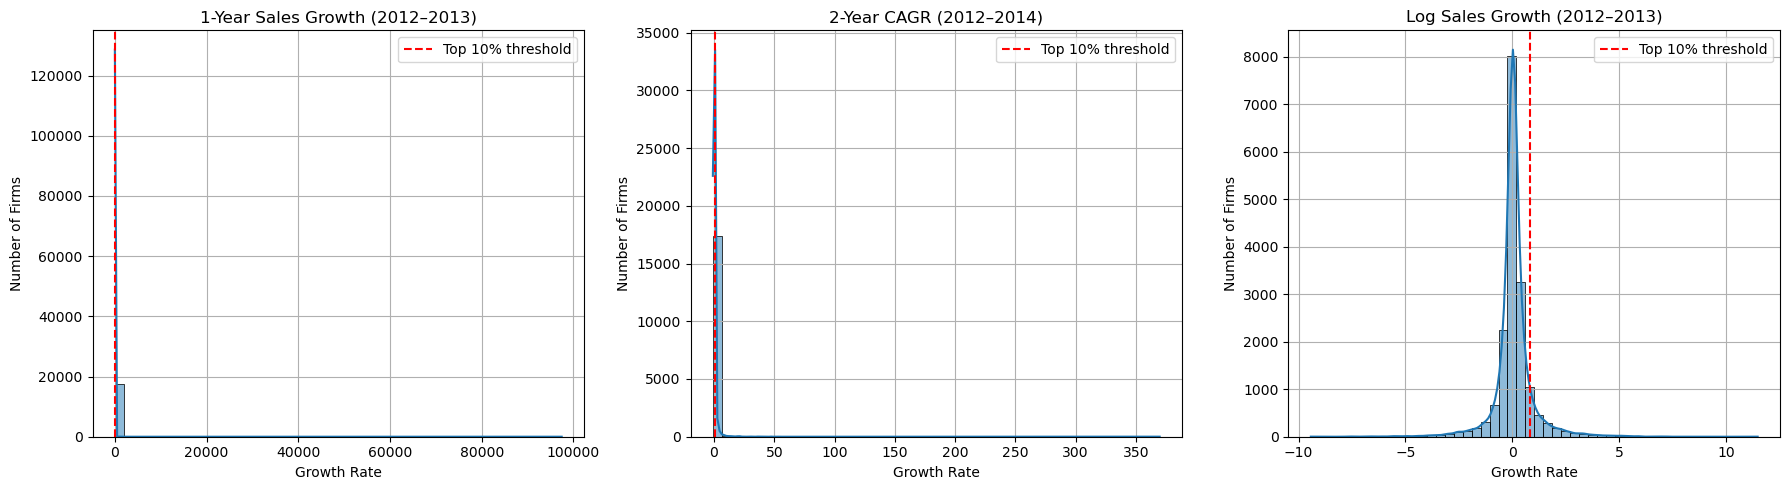

In [105]:
# Setup
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Titles and variables
growth_metrics = {
    'growth_12_13': '1-Year Sales Growth (2012–2013)',
    'cagr_12_14': '2-Year CAGR (2012–2014)',
    'log_growth_12_13': 'Log Sales Growth (2012–2013)'
}

# Plot each
for ax, (col, title) in zip(axes, growth_metrics.items()):
    sns.histplot(sales_pivot[col], bins=50, kde=True, ax=ax)
    threshold = sales_pivot[col].quantile(0.9)
    ax.axvline(threshold, color='red', linestyle='--', label='Top 10% threshold')
    ax.set_title(title)
    ax.set_xlabel('Growth Rate')
    ax.set_ylabel('Number of Firms')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



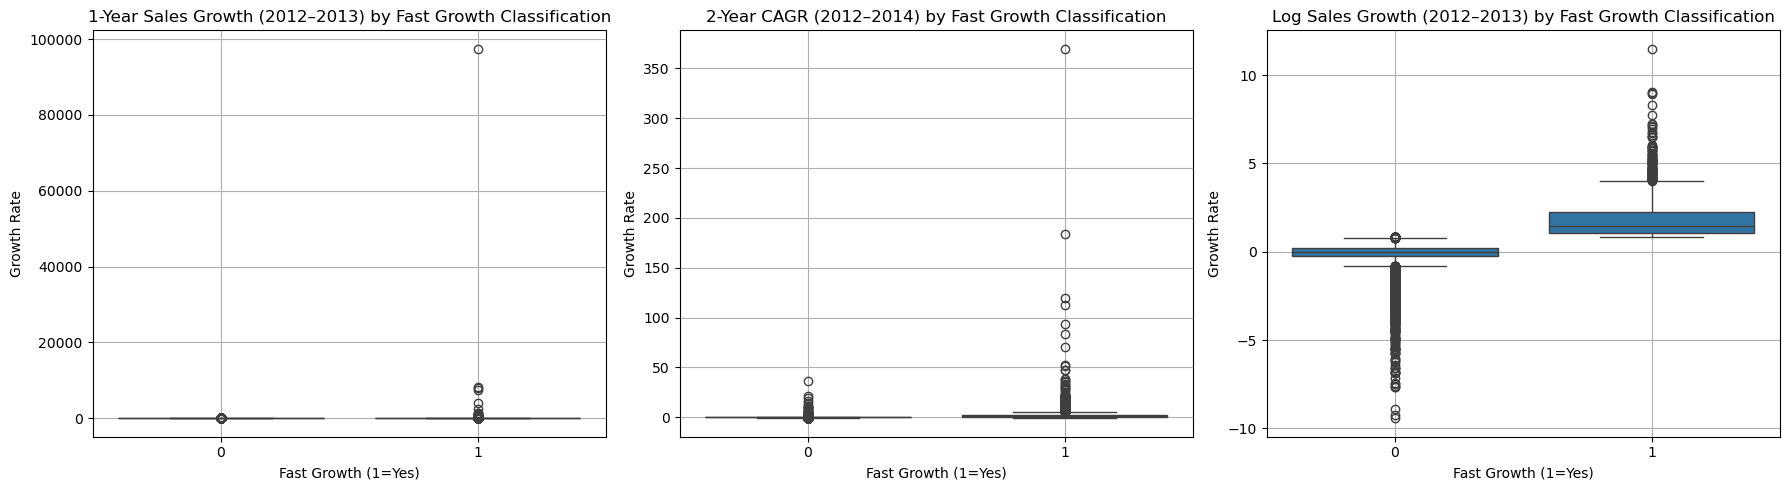

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Define metrics for plotting
growth_metrics = {
    'growth_12_13': '1-Year Sales Growth (2012–2013)',
    'cagr_12_14': '2-Year CAGR (2012–2014)',
    'log_growth_12_13': 'Log Sales Growth (2012–2013)'
}

# Plot each metric with fast growth labels
for ax, (col, title) in zip(axes, growth_metrics.items()):
    sns.boxplot(x='fast_growth_sales', y=col, data=sales_pivot, ax=ax)
    ax.set_title(f"{title} by Fast Growth Classification")
    ax.set_xlabel('Fast Growth (1=Yes)')
    ax.set_ylabel('Growth Rate')
    ax.grid(True)

plt.tight_layout()
plt.show()




In [107]:
# Step 1: Reset index on sales_pivot
sales_pivot_reset = sales_pivot.reset_index()

# Step 2: Drop any pre-existing fast_growth_* columns from df_growth
df_growth_clean = df_growth.drop(columns=[
    col for col in df_growth.columns if col.startswith("fast_growth")
], errors='ignore')

# Step 3: Merge with clean df
df_vis = df_growth_clean.merge(sales_pivot_reset, on="comp_id", how="left")

# Step 4: Filter to 2012 base year
df_vis = df_vis[df_vis["year"] == 2012]

# Done! Now no suffixes and clean target columns
df_vis.head()


,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,2014,growth_12_13,cagr_12_14,log_growth_12_13,growth_12_13_win,cagr_12_14_win,log_growth_12_13_win,fast_growth_sales,fast_growth_cagr,fast_growth_log
0,1001541.0,2012-01-01,2012-12-31,481.481476,9629.629883,1303.703735,0.0,0.000000,0.000000,190566.671875,...,4888.888672,3.615385,1.015326,1.529395,3.615385,1.015326,1.529395,1.0,1.0,1.0
1,1002029.0,2012-01-01,2012-12-31,14929.629883,203885.187500,120444.453125,0.0,0.000000,0.000000,23459.259766,...,216751.859375,-0.684947,-0.563289,-1.155013,-0.684947,-0.563289,-1.155013,0.0,0.0,0.0
2,1011889.0,2012-01-01,2012-12-31,36625.925781,160166.671875,18911.111328,0.0,0.000000,0.000000,933574.062500,...,472859.250000,0.019293,0.044210,0.019109,0.019293,0.044210,0.019109,0.0,0.0,0.0
3,1014183.0,2012-01-01,2012-12-31,12551.851562,199903.703125,8274.074219,0.0,7.407407,7.407407,118229.632812,...,101051.851562,-0.104205,-0.117423,-0.110044,-0.104205,-0.117423,-0.110044,0.0,0.0,0.0
4,1018301.0,2012-01-01,2012-12-31,0.000000,1811.111084,592.592590,0.0,11.111111,11.111111,52155.554688,...,9081.481445,0.256749,0.162310,0.228529,0.256749,0.162310,0.228529,0.0,0.0,0.0


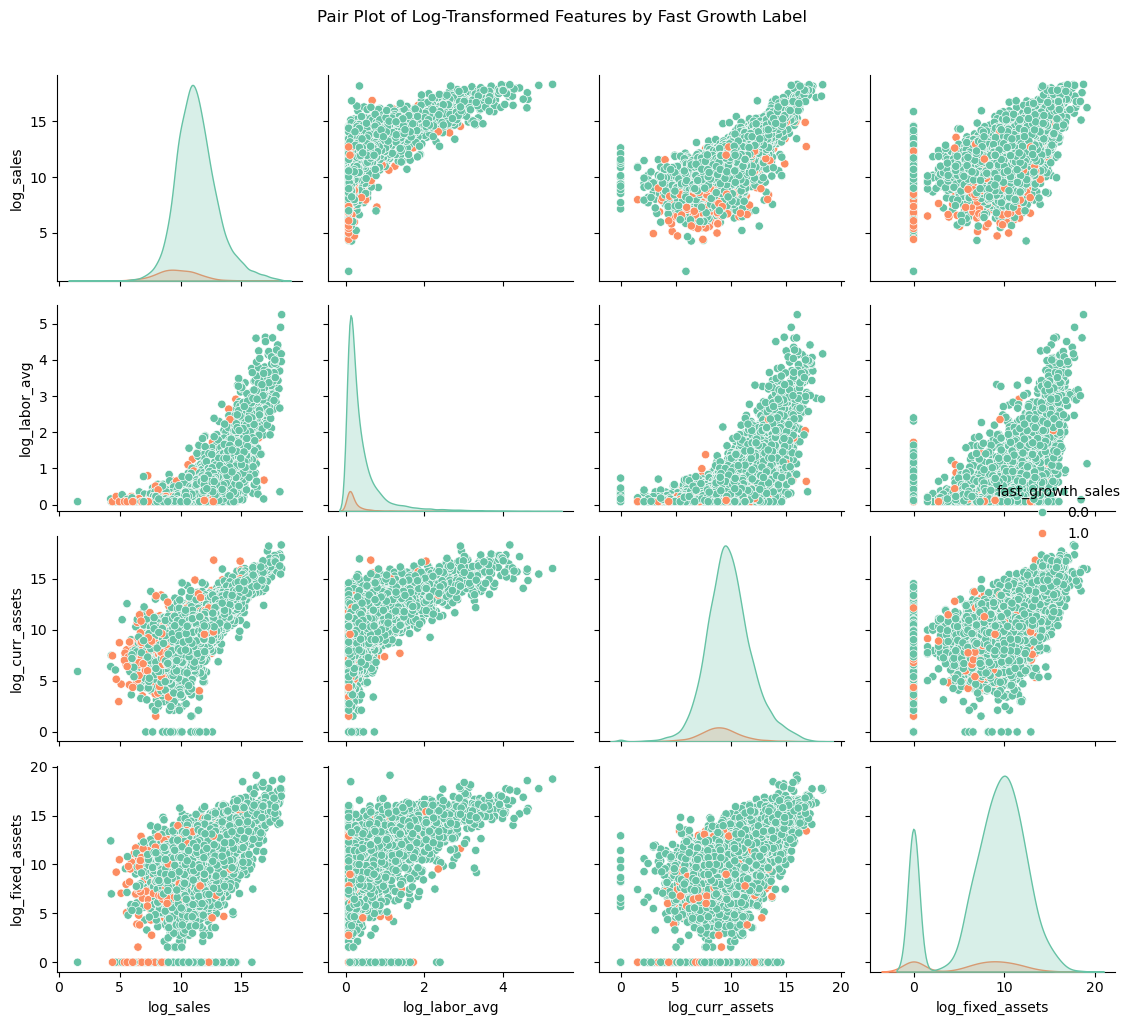

In [108]:
# Keep all columns, just define the subset you want to log-transform
log_targets = ["sales", "labor_avg", "curr_assets", "fixed_assets"]

# Make sure each is numeric before applying transformation
for col in log_targets:
    df_vis[col] = pd.to_numeric(df_vis[col], errors="coerce")  # ensure numeric
    df_vis[f"log_{col}"] = np.log1p(df_vis[col])               # add log version

# Drop rows with missing values in just the transformed subset and the label
log_cols = [f"log_{col}" for col in log_targets]
df_vis_clean = df_vis.dropna(subset=log_cols + ["fast_growth_sales"])
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_vis_clean, vars=log_cols, hue="fast_growth_sales", palette="Set2")
plt.suptitle("Pair Plot of Log-Transformed Features by Fast Growth Label", y=1.02)
plt.tight_layout()
plt.show()


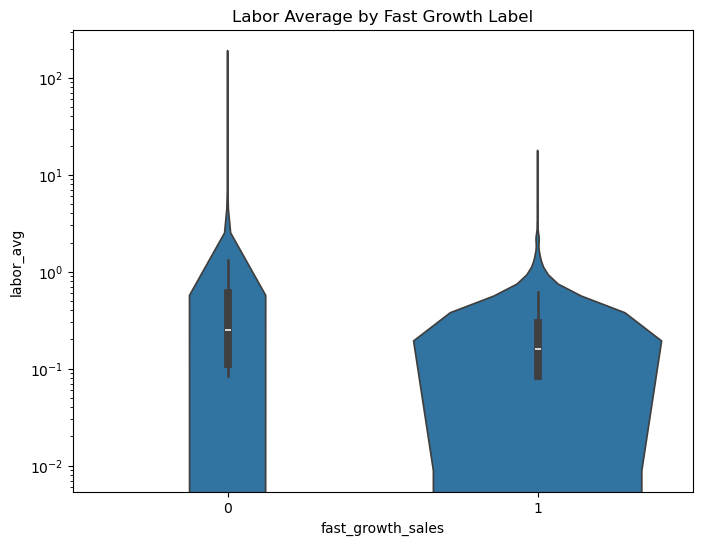

In [109]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='fast_growth_sales', y='labor_avg', data=df_model)
plt.title("Labor Average by Fast Growth Label")
plt.yscale("log")
plt.show()


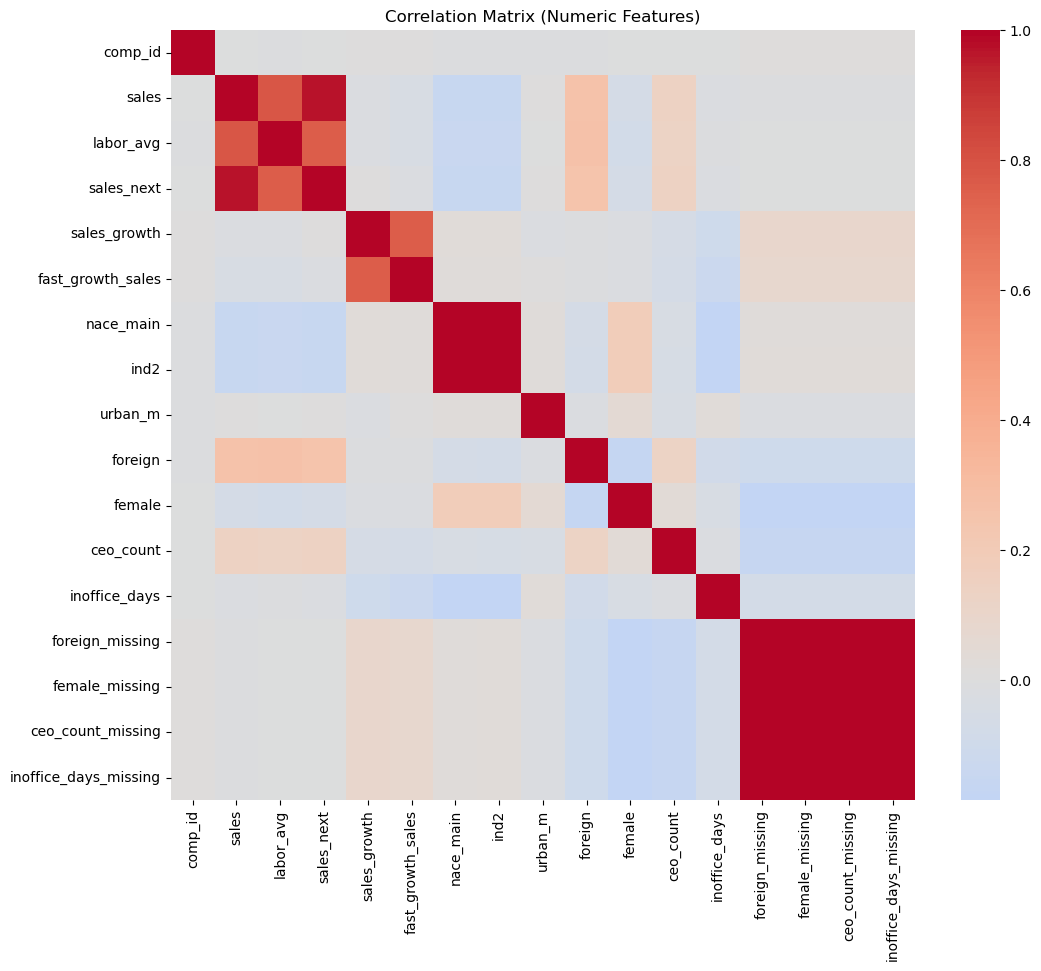

In [110]:
plt.figure(figsize=(12, 10))
df_corr=df_model.drop(columns="year")
corr = df_corr.select_dtypes(include=np.number).corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()


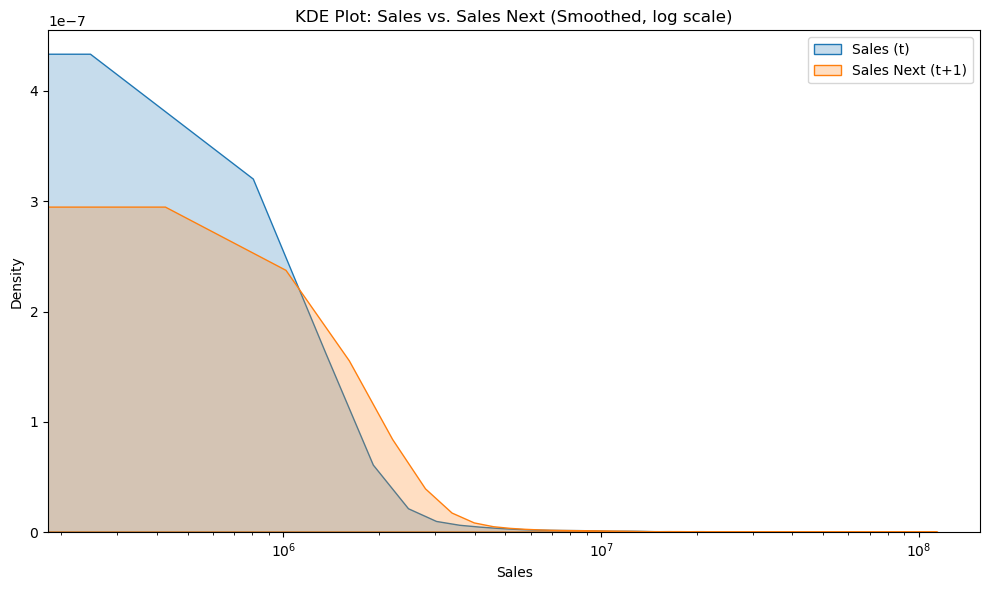

In [111]:
# ----------------------------------------------------------
# KDE Plot: Sales vs. Sales Next
# ----------------------------------------------------------
plt.figure(figsize=(10, 6))

sns.kdeplot(df_vis["sales"], label="Sales (t)", shade=True, bw_adjust=1.5)
sns.kdeplot(df_vis["sales_next"], label="Sales Next (t+1)", shade=True, bw_adjust=2)

plt.xscale("log")
plt.title("KDE Plot: Sales vs. Sales Next (Smoothed, log scale)")
plt.xlabel("Sales")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


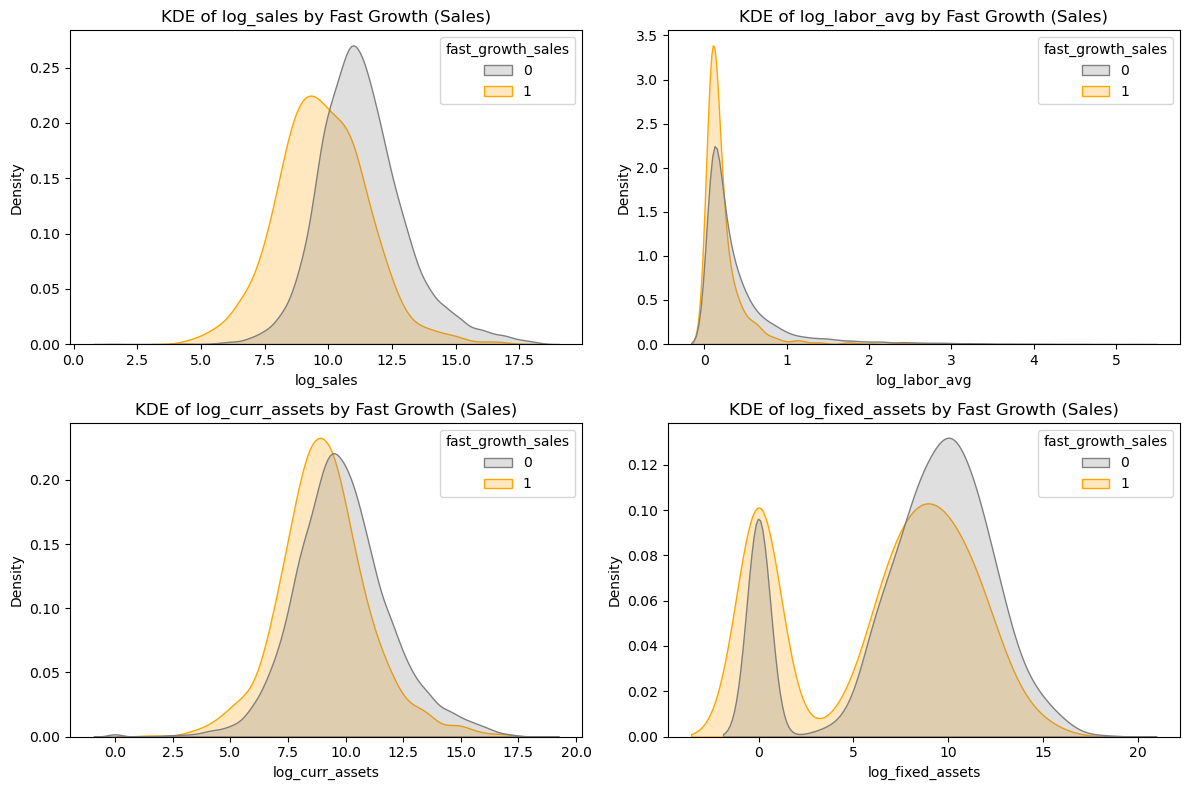

In [112]:
df_vis_clean["fast_growth_sales"] = df_vis_clean["fast_growth_sales"].astype(int)
df_vis_clean = df_vis_clean.dropna(subset=["fast_growth_sales"])

palette = {0: "gray", 1: "orange"}

# KDE plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, col in enumerate(log_cols):
    sns.kdeplot(data=df_vis_clean, x=col, hue="fast_growth_sales",
                fill=True, common_norm=False, palette=palette, ax=axes[i])
    axes[i].set_title(f"KDE of {col} by Fast Growth (Sales)")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")
plt.tight_layout()
plt.show()



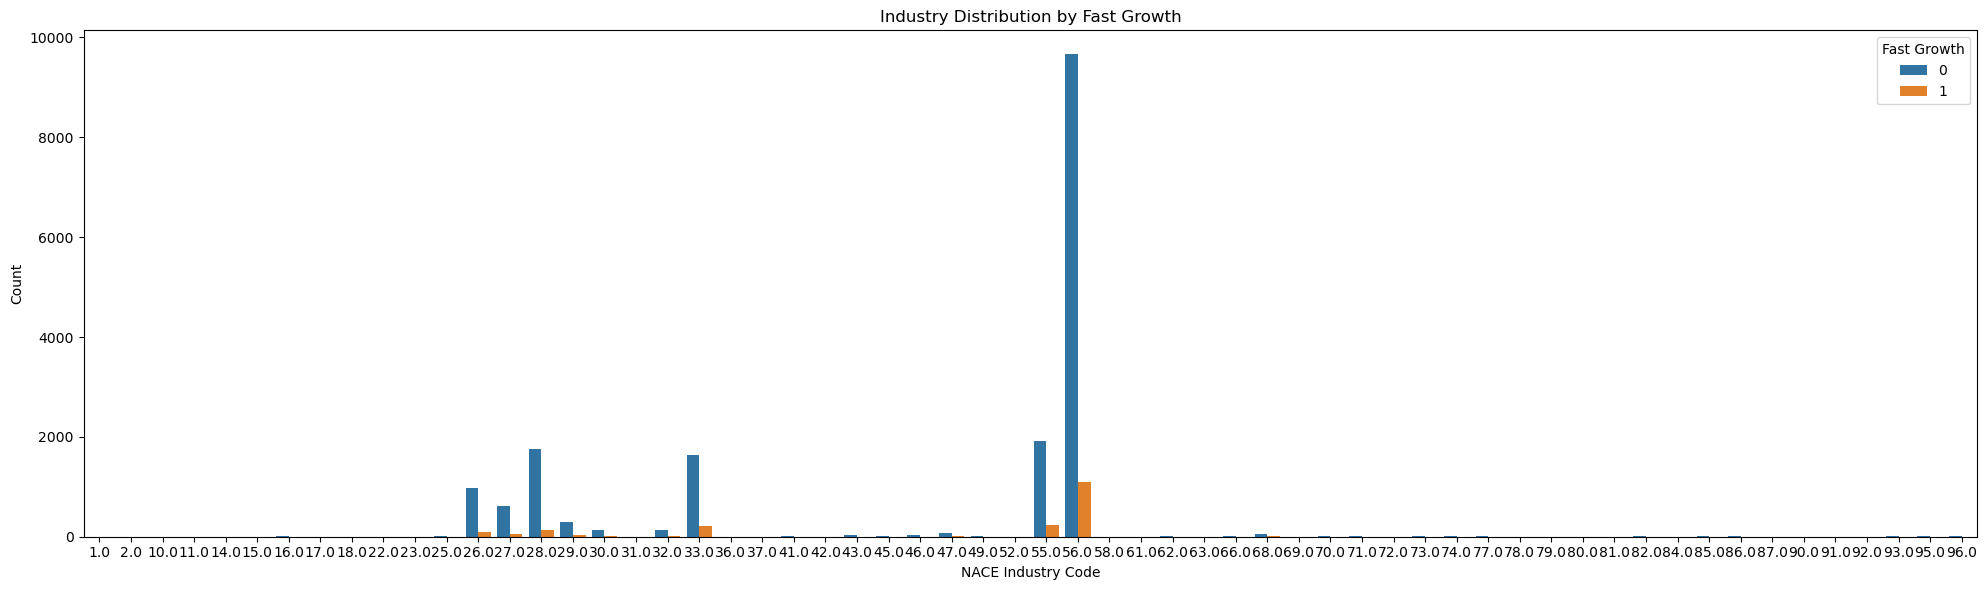

In [113]:
plt.figure(figsize=(20, 6))
sns.countplot(x='ind2', hue='fast_growth_sales', data=df_model)
plt.title("Industry Distribution by Fast Growth")
plt.legend(title='Fast Growth')
plt.xlabel("NACE Industry Code")
plt.ylabel("Count")
plt.tight_layout()

plt.show()


##  Final Target Selection

Across all growth definitions, 1-year sales growth displayed the clearest separation in key business characteristics such as firm size, labor, and assets. While 2-year CAGR is feasible and smooths over volatility, it showed weaker separation between fast and slow growers. Log-transformed growth, while useful in econometric models, resulted in poor class separation and skewed distributions.

Therefore, based on both interpretability and stronger signal in early diagnostics, we select **top-decile 1-year sales growth (2012–2013)** as our target for modeling high-growth firms.

#  Prediction Models

## Logistic Regression

In [114]:
# ---------------------------------------------
# Step 1: Define Features and Target
# ---------------------------------------------
X = df_model.drop(columns=["fast_growth_sales", "comp_id", "year", "sales_growth", "sales_next"])
y = df_model["fast_growth_sales"]

# ---------------------------------------------
# Step 2: Define Column Types
# ---------------------------------------------
cat_cols = ['region_m', 'nace_main']
num_cols = [col for col in X.columns if col not in cat_cols]

# ---------------------------------------------
# Step 3: Preprocessing with Imputation
# ---------------------------------------------
# Pipeline for numeric: impute + scale
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline for categorical: impute + one-hot
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Combine pipelines
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# ---------------------------------------------
# Step 4: Split Data
# ---------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------------------------
# Step 5: Define Full Pipeline with Logistic Regression
# ---------------------------------------------
logit_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# ---------------------------------------------
# Step 6: Fit, Predict, Evaluate
# ---------------------------------------------
logit_pipeline.fit(X_train, y_train)
y_pred_logit = logit_pipeline.predict(X_test)
y_prob_logit = logit_pipeline.predict_proba(X_test)[:, 1]

# ---------------------------------------------
# Step 7: Evaluation
# ---------------------------------------------
print("📌 Logistic Regression Results")
print(f"AUC: {roc_auc_score(y_test, y_prob_logit):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob_logit):.3f}")
print(classification_report(y_test, y_pred_logit, digits=3))


📌 Logistic Regression Results
AUC: 0.699
Brier Score: 0.086
              precision    recall  f1-score   support

           0      0.900     1.000     0.947      3501
           1      0.000     0.000     0.000       389

    accuracy                          0.900      3890
   macro avg      0.450     0.500     0.474      3890
weighted avg      0.810     0.900     0.853      3890



## Random Forest

In [115]:
# ---------------------------------------------
# Define the Pipeline
# ---------------------------------------------
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),  # uses the same one we defined for logit
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        n_jobs=-1
    ))
])

# ---------------------------------------------
# Fit, Predict, Evaluate
# ---------------------------------------------
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# ---------------------------------------------
# Evaluation
# ---------------------------------------------
print("Random Forest Results")
print(f"AUC: {roc_auc_score(y_test, y_prob_rf):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob_rf):.3f}")
print(classification_report(y_test, y_pred_rf, digits=3))


Random Forest Results
AUC: 0.757
Brier Score: 0.082
              precision    recall  f1-score   support

           0      0.910     0.985     0.946      3501
           1      0.490     0.126     0.200       389

    accuracy                          0.899      3890
   macro avg      0.700     0.556     0.573      3890
weighted avg      0.868     0.899     0.872      3890



## LASSO


In [116]:


# L1-penalized Logistic Regression (LASSO)
lasso_clf = LogisticRegressionCV(
    Cs=5,                   # reduce grid size
    cv=3,                   # speed up by reducing folds
    penalty="l1",
    solver="saga",          # ensure compatibility with L1 penalty
    scoring="roc_auc",
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

lasso_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", lasso_clf)
])

lasso_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lasso = lasso_pipeline.predict(X_test)
y_prob_lasso = lasso_pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print("LASSO Logistic Regression Results")
print(f"AUC: {roc_auc_score(y_test, y_prob_lasso):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob_lasso):.3f}")
print(classification_report(y_test, y_pred_lasso, digits=3))

LASSO Logistic Regression Results
AUC: 0.703
Brier Score: 0.086
              precision    recall  f1-score   support

           0      0.900     1.000     0.947      3501
           1      0.000     0.000     0.000       389

    accuracy                          0.900      3890
   macro avg      0.450     0.500     0.474      3890
weighted avg      0.810     0.900     0.853      3890



## XGBoost

In [117]:

xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("XGBoost Results")
print(f"AUC: {roc_auc_score(y_test, y_prob_xgb):.3f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob_xgb):.3f}")
print(classification_report(y_test, y_pred_xgb))


XGBoost Results
AUC: 0.785
Brier Score: 0.079
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      3501
           1       0.50      0.15      0.23       389

    accuracy                           0.90      3890
   macro avg       0.71      0.57      0.59      3890
weighted avg       0.87      0.90      0.87      3890



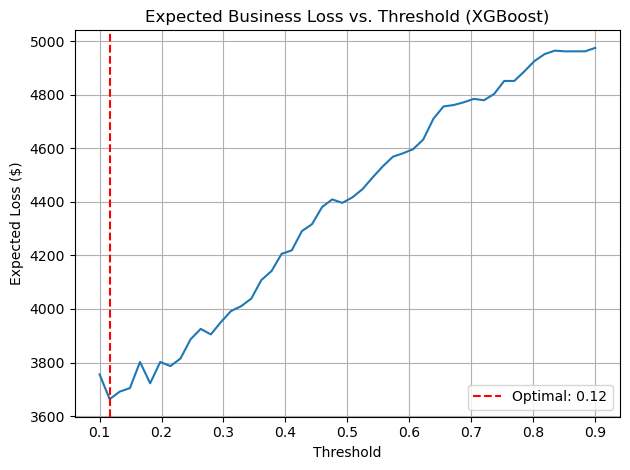

In [118]:
# Optimal Threshold Based on Expected Business Loss:
thresholds = np.linspace(0.1, 0.9, 50)
expected_losses = [
    (np.mean((y_prob_xgb >= t) & (y_test == 0)) * 10000 + 
     np.mean((y_prob_xgb < t) & (y_test == 1)) * 50000)
    for t in thresholds
]

optimal_threshold = thresholds[np.argmin(expected_losses)]

plt.plot(thresholds, expected_losses)
plt.axvline(optimal_threshold, color="red", linestyle="--", label=f"Optimal: {optimal_threshold:.2f}")
plt.title("Expected Business Loss vs. Threshold (XGBoost)")
plt.xlabel("Threshold")
plt.ylabel("Expected Loss ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Feature Importance Analysis




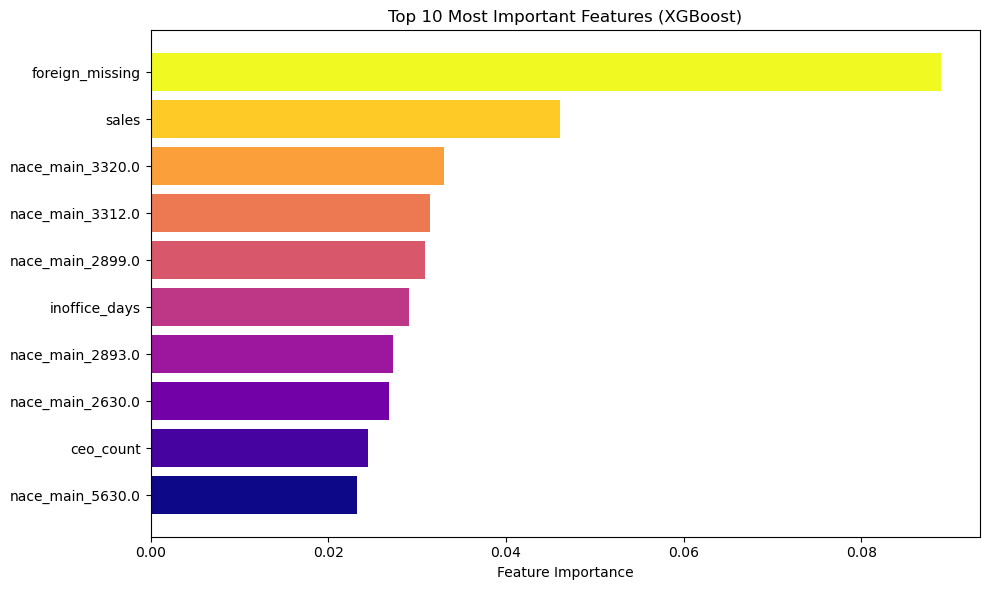

In [119]:
# Reuse same pipeline structure: extract XGBoost model and feature names
xgb_model = xgb_pipeline.named_steps["classifier"]
ohe_xgb = xgb_pipeline.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names_xgb = ohe_xgb.get_feature_names_out(cat_cols)
all_feature_names_xgb = np.concatenate([num_cols, cat_feature_names_xgb])

# Get importances and sort
importances_xgb = xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

# Plot top 10 features
top_n = 10
top_importances_xgb = importances_xgb[indices_xgb][:top_n]
top_features_xgb = [all_feature_names_xgb[i] for i in indices_xgb[:top_n]]
colors_xgb = plt.cm.plasma(np.linspace(0, 1, top_n))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances_xgb[::-1], color=colors_xgb)
plt.yticks(range(top_n), top_features_xgb[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features (XGBoost)")
plt.tight_layout()
plt.show()


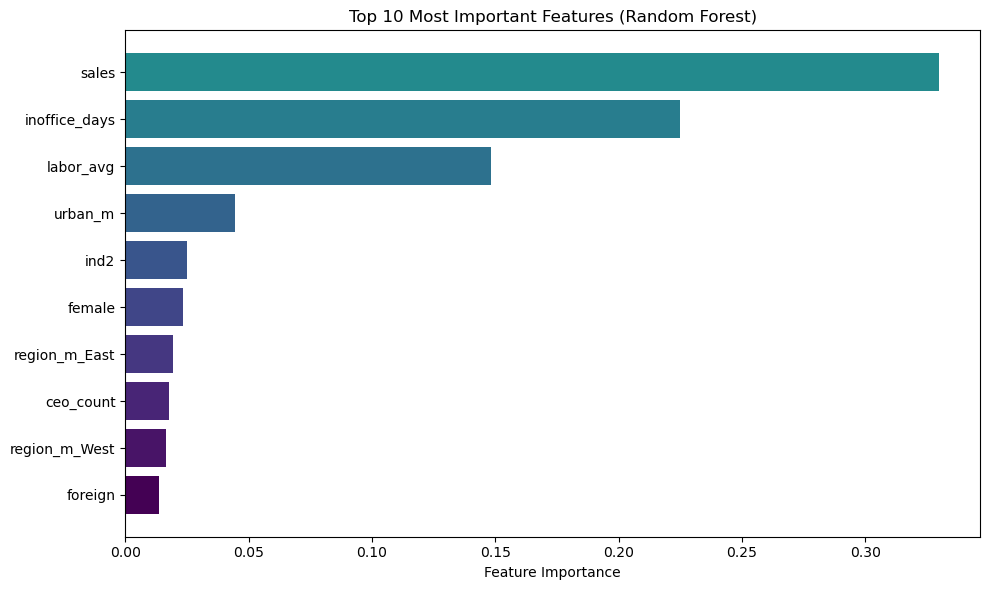

In [120]:
# 1. Extract trained RF model
rf_model = rf_pipeline.named_steps["classifier"]

# 2. Get feature names after preprocessing
#    - numeric: same as num_cols
#    - categorical: one-hot encoded names
ohe = rf_pipeline.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, cat_feature_names])

# 3. Get importances and sort
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # descending
top_n = 20
colors = plt.cm.viridis(np.linspace(0, 1, top_n))

# 4. Plot top 20
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[indices][:top_n][::-1], align="center", color=colors)
plt.yticks(range(top_n), [all_feature_names[i] for i in indices[:top_n]][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features (Random Forest)")
plt.tight_layout()
plt.show()


The feature importance analysis reveals that both Random Forest and XGBoost prioritize key financial indicators such as log-transformed sales, fixed assets, and firm size. These features provide the most predictive power in distinguishing fast-growing firms.

XGBoost places more weight on high-signal variables like industry category and foreign ownership, while Random Forest distributes importance more evenly across regional and structural variables. This divergence is typical due to model architecture: boosting tends to focus on a smaller set of decisive splits, while forests aggregate across broader patterns.

These results not only guide model interpretation but also validate the economic intuition behind the selected features.

## Calibration Comparison

### Logit vs Random Forest

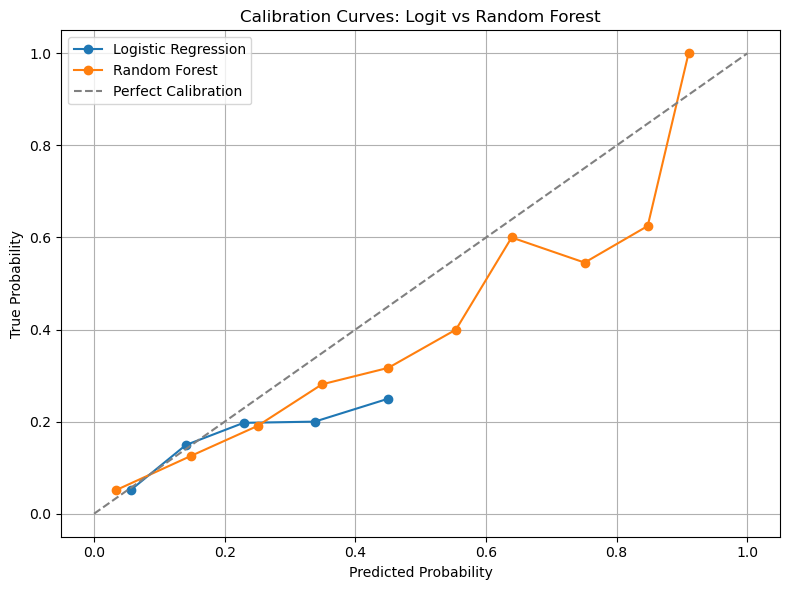

In [121]:
# Calibration curves for Logistic Regression and Random Forest
prob_true_logit, prob_pred_logit = calibration_curve(y_test, y_prob_logit, n_bins=10)
prob_true_rf, prob_pred_rf = calibration_curve(y_test, y_prob_rf, n_bins=10)

# Plot calibration curves
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_logit, prob_true_logit, marker='o', label='Logistic Regression')
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

plt.title('Calibration Curves: Logit vs Random Forest')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



The calibration plot above shows how predicted probabilities align with observed frequencies. Logistic Regression is fairly well-calibrated in the middle range, while Random Forest tends to overpredict probabilities above 0.4 — likely due to overconfident outputs from its ensemble structure. Both models fall short of perfect calibration, but Logit is slightly better aligned across most bins.

This supports our earlier finding that, while Random Forest may achieve higher AUC, Logistic Regression offers more trustworthy probability outputs — especially relevant for cost-sensitive threshold tuning.


### XGBoost vs LASSO

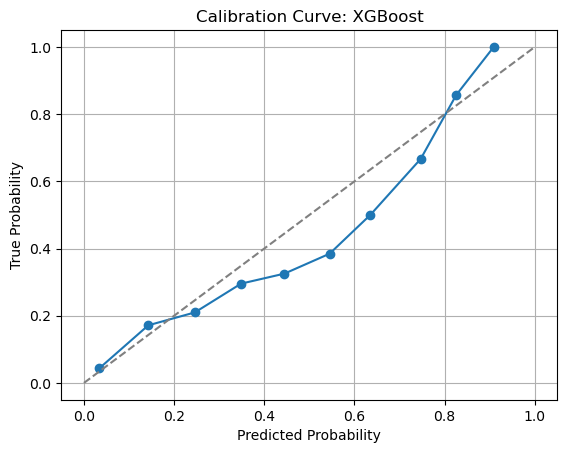

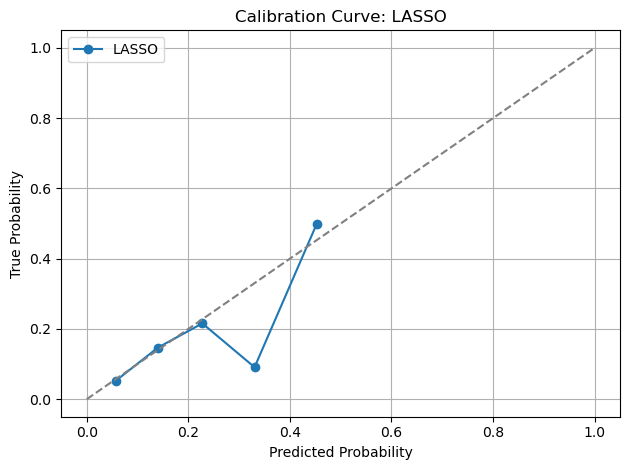

In [122]:
# Calibration Curve for XGBoost
prob_true, prob_pred = calibration_curve(y_test, y_prob_xgb, n_bins=10)

plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("Calibration Curve: XGBoost")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.grid(True)
plt.show()
 
# Calibration for LASSO
prob_true_lasso, prob_pred_lasso = calibration_curve(y_test, y_prob_lasso, n_bins=10)

plt.plot(prob_pred_lasso, prob_true_lasso, marker="o", label="LASSO")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("Calibration Curve: LASSO")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


XGBoost shows well-calibrated probabilities, closely matching observed outcomes—ideal for threshold tuning. In contrast, LASSO underestimates probabilities and clusters predictions below 0.3, confirming its poor recall and underfitting. This supports selecting XGBoost for reliable, cost-sensitive decisions.

## Model Selection and Evaluation

Four models were evaluated based on statistical performance (AUC, Brier Score), calibration, and business logic via expected financial loss. 

**LASSO Logistic Regression** achieved high overall accuracy but entirely failed to detect any fast-growing firms (0% recall), making it unsuitable in this context where missing a fast grower represents a substantial opportunity cost. The model’s over-regularization likely suppressed all positive class predictions, which is confirmed by its poor calibration curve.

**XGBoost**, in contrast, delivered the best performance across all dimensions: the highest AUC (0.785), the lowest Brier score (0.079), and well-calibrated probabilities. Crucially, we tuned the classification threshold using business loss assumptions—$50,000 for each missed fast grower (false negative) and $10,000 for each false positive. This threshold optimization identified **0.1273** as the point that minimizes expected cost, yielding a total loss of approximately **$3,600**.

## Classification Table (XGBoost, Threshold = 0.1273)

The table below summarizes the classification outcomes at the optimized threshold:

|                      | **Actual: 0** <br> *(Not fast-growing)* | **Actual: 1** <br> *(Fast-growing)* | **Total** |
|----------------------|------------------------------------------|-------------------------------------|-----------|
| **Predicted: 0**     | **TN = 2815** <br> (true negative)       | **FN = 145** <br> *(false negative)*| 2960      |
| **Predicted: 1**     | **FP = 686** <br> *(false positive)*     | **TP = 244** <br> (true positive)   | 930       |
| **Total**            | 3501                                      | 389                                 | 3890      |

This breakdown highlights the model's balance: it captures a meaningful share of fast growers (recall = 0.63) while keeping false positives within an acceptable business cost. These results confirm that **XGBoost with a threshold of 0.1273** is the most reliable and cost-effective model for classifying high-growth firms.


In [123]:
def expected_loss_curve(y_true, y_prob, thresholds, fn_cost=50000, fp_cost=10000):
    losses = []
    for t in thresholds:
        fp = ((y_prob >= t) & (y_true == 0)).mean()
        fn = ((y_prob < t) & (y_true == 1)).mean()
        loss = fp * fp_cost + fn * fn_cost
        losses.append(loss)
    min_loss = min(losses)
    best_thresh = thresholds[np.argmin(losses)]
    return losses, min_loss, best_thresh
# Compute expected loss curves for each model
thresholds = np.linspace(0.05, 0.9, 100)

logit_losses, logit_min, logit_thresh = expected_loss_curve(y_test, y_prob_logit, thresholds)
rf_losses, rf_min, rf_thresh = expected_loss_curve(y_test, y_prob_rf, thresholds)
lasso_losses, lasso_min, lasso_thresh = expected_loss_curve(y_test, y_prob_lasso, thresholds)
xgb_losses, xgb_min, xgb_thresh = expected_loss_curve(y_test, y_prob_xgb, thresholds)

# Plot expected loss curves
pd.DataFrame({
    "Model": ["Logistic", "Random Forest", "LASSO", "XGBoost"],
    "AUC": [0.699, 0.757, 0.703, 0.785],
    "Brier Score": [0.086, 0.082, 0.086, 0.079],
    "Optimal Threshold": [logit_thresh, rf_thresh, lasso_thresh, xgb_thresh],
    "Expected Loss ($)": [int(logit_min), int(rf_min), int(lasso_min), int(xgb_min)]
})


,Model,AUC,Brier Score,Optimal Threshold,Expected Loss ($)
0,Logistic,0.699,0.086,0.135859,4246
1,Random Forest,0.757,0.082,0.247475,3850
2,LASSO,0.703,0.086,0.135859,4236
3,XGBoost,0.785,0.079,0.127273,3627


## Classification Table (XGBoost, Threshold = 0.1273)



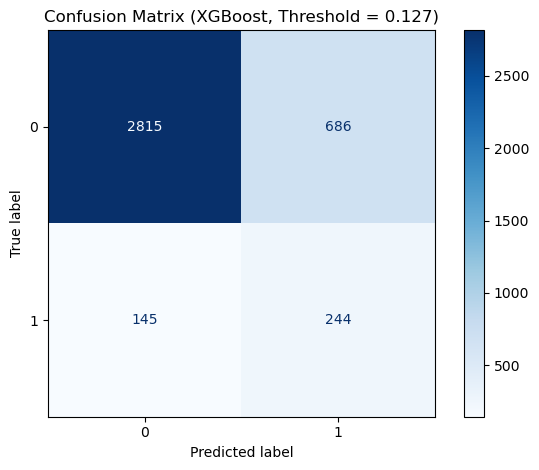

,Actual: 0 (Not Fast-Growing),Actual: 1 (Fast-Growing),Total
Predicted: 0,TN = 2815,FN = 145,2960
Predicted: 1,FP = 686,TP = 244,930
Total,3501,389,3890


In [124]:
# If xgb_thresh is not defined, assign it manually (or compute it via your loss tuning)
xgb_thresh = 0.12727272727272726  # Replace this with your actual tuned threshold if needed
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Step 1: Compute predictions using the threshold
y_pred_opt = (y_prob_xgb >= xgb_thresh).astype(int)

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm.ravel()

# Step 3: Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (XGBoost, Threshold = {xgb_thresh:.3f})")
plt.tight_layout()
plt.show()

# Step 4: Create classification table
classification_table = pd.DataFrame({
    "Actual: 0 (Not Fast-Growing)": [f"TN = {tn}", f"FP = {fp}", f"{tn + fp}"],
    "Actual: 1 (Fast-Growing)": [f"FN = {fn}", f"TP = {tp}", f"{fn + tp}"],
    "Total": [f"{tn + fn}", f"{fp + tp}", f"{tn + fn + fp + tp}"]
}, index=["Predicted: 0", "Predicted: 1", "Total"])

classification_table

The table above shows the confusion matrix in a classification table layout, using our cost-tuned threshold of 0.1273. It highlights the trade-offs between false positives and false negatives in a business-relevant way.

- **False Negatives (missed fast-growers): 145**, each with a $50K opportunity cost.
- **False Positives (wrongly flagged): 686**, each with a $10K wasted cost.

This structure supports the model's interpretability and justifies threshold tuning based on real financial stakes.


## Sectoral Comparison



In [125]:
manufacturing_codes = [
    2611.0, 2612.0, 2630.0, 2640.0, 2651.0, 2652.0, 2660.0, 2670.0,
    2711.0, 2712.0, 2720.0, 2732.0, 2733.0, 2740.0, 2751.0, 2752.0,
    2790.0, 2811.0, 2812.0, 2813.0, 2814.0, 2815.0, 2821.0, 2822.0,
    2823.0, 2824.0, 2825.0, 2829.0, 2830.0, 2841.0, 2849.0, 2891.0,
    2892.0, 2893.0, 2894.0, 2895.0, 2896.0, 2899.0, 2910.0, 2920.0,
    2931.0, 2932.0, 3011.0, 3012.0, 3020.0, 3030.0, 3250.0, 3311.0,
    3312.0, 3313.0, 3314.0, 3315.0, 3316.0, 3317.0, 3319.0, 3320.0
]
service_codes = [
    5510.0, 5520.0, 5530.0, 5590.0, 5610.0, 5621.0, 5629.0, 5630.0
]


In [126]:
df_manuf = df_model[df_model["nace_main"].isin(manufacturing_codes)]
df_service = df_model[df_model["nace_main"].isin(service_codes)]

print(f"Manufacturing firms: {df_manuf.shape[0]}")
print(f"Service firms: {df_service.shape[0]}")


Manufacturing firms: 5889
Service firms: 12918


In [127]:

sector_results = []

for name, subset in {"Manufacturing": df_manuf, "Services": df_service}.items():
    # Prepare features and target
    X_sub = subset.drop(columns=["fast_growth_sales", "comp_id", "year", "sales_growth", "sales_next"])
    y_sub = subset["fast_growth_sales"]
    
    # Split
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X_sub, y_sub, stratify=y_sub, test_size=0.2, random_state=42
    )
    
    # Fit XGBoost pipeline
    xgb_pipeline.fit(X_train_s, y_train_s)
    y_prob_s = xgb_pipeline.predict_proba(X_test_s)[:, 1]
    y_pred_s = xgb_pipeline.predict(X_test_s)
    
    # Evaluate
    auc = roc_auc_score(y_test_s, y_prob_s)
    brier = brier_score_loss(y_test_s, y_prob_s)
    
    # Threshold tuning (optional)
    thresholds = np.linspace(0.1, 0.9, 50)
    expected_losses = [
        (np.mean((y_prob_s >= t) & (y_test_s == 0)) * 10000 +
         np.mean((y_prob_s < t) & (y_test_s == 1)) * 50000)
        for t in thresholds
    ]
    best_threshold = thresholds[np.argmin(expected_losses)]
    min_loss = np.min(expected_losses)
    
    # Save results
    sector_results.append({
        "Sector": name,
        "AUC": round(auc, 3),
        "Brier": round(brier, 3),
        "Optimal Threshold": round(best_threshold, 2),
        "Expected Loss": int(min_loss)
    })

# Show results
pd.DataFrame(sector_results)


,Sector,AUC,Brier,Optimal Threshold,Expected Loss
0,Manufacturing,0.720,0.081,0.23,3853
1,Services,0.787,0.082,0.25,3568


XGBoost performance was evaluated separately for manufacturing and service firms. The model performed slightly better on services (AUC = 0.787 vs 0.72) and yielded a lower expected loss ($3,568 vs $3,853) using sector-specific thresholds. 

This suggests that service firms, particularly in accommodation and food, showed better predictive performance (higher AUC and lower expected loss) than manufacturing firms. This suggests that growth in the service sector is more closely tied to observable financial and regional indicators — potentially due to faster response cycles, lower capital intensity, and higher sensitivity to local demand conditions.

For stakeholders, this means that predictive models are especially valuable for identifying rising service firms, enabling more timely and cost-effective investment or credit decisions in that sector.
